In [1]:
import sys

sys.path.append("..")

In [2]:
import os
from pathlib import Path

import geopandas as gpd
import pandas as pd
import rioxarray
import numpy as np
import xarray as xr
from dask.distributed import Client
from tqdm import tqdm

from src.utils import expand_grid

In [4]:
client = Client()

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43301 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43301/status,
Dashboard: http://127.0.0.1:43301/status,Workers: 5
Total threads: 20,Total memory: 62.44 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44563,Workers: 5
Dashboard: http://127.0.0.1:43301/status,Total threads: 20
Started: Just now,Total memory: 62.44 GiB
Comm: tcp://127.0.0.1:45611,Total threads: 4
Dashboard: http://127.0.0.1:32815/status,Memory: 12.49 GiB
Nanny: tcp://127.0.0.1:43313,


In [6]:
# Load template to start merging

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Notice template is 1 for land and 0 for water
template_df = (
    template.rename({"x": "lon", "y": "lat"})
    .to_dataframe(name="id_template")
    .reset_index()
    .dropna()
)
template_df["grid_id"] = template_df.index

# Remove the water pixels
template_df = template_df[template_df.id_template == 1]

# Create grid for all years in the sample
template_expanded = expand_grid(
    {"grid_id": template_df.grid_id, "year": np.arange(2000, 2023)}
)

# Add lat and lon to the expanded grid
template_expanded = template_expanded.merge(
    template_df[["grid_id", "lat", "lon"]], on="grid_id"
)

# Build panel dataset 

In [7]:
# Load treatments feather data
df_treats = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
)
df_treats = df_treats.merge(template_expanded, on=["lat", "lon", "year"])


### Load PRISM

In [11]:
# Load all covariates
path_to_prism = "/mnt/sherlock/oak/prescribed_data/processed/prism_template/prism"

# Prism
prism_vars = ["tmin", "tmax", "tdmean", "vpdmin", "vpdmax", "ppt", "tmean"]
prism_data = [
    xr.open_dataset(
        os.path.join(path_to_prism, f"prism_processed_{var}.nc"), chunks={"time": 10}
    )
    for var in prism_vars
]

# Merge in the same file
prism_all = xr.merge(prism_data)

In [12]:
df_prism = prism_all.to_dataframe().reset_index().dropna()
df_prism

,lat,lon,time,tmin,tmax,tdmean,vpdmin,vpdmax,ppt,tmean
1132200,447152.596997,-346913.82085,1988-01-01,3.619000,11.102000,4.071000,0.3140,4.511000,400.201996,7.360000
1132201,447152.596997,-346913.82085,1988-02-01,3.991000,12.955000,3.749000,0.6750,6.853000,43.265999,8.472000
1132202,447152.596997,-346913.82085,1988-03-01,2.844000,14.153000,3.050000,0.5740,8.572000,129.395996,8.498000
1132203,447152.596997,-346913.82085,1988-04-01,5.556000,14.858000,5.948000,0.5010,7.535000,135.018005,10.207001
1132204,447152.596997,-346913.82085,1988-05-01,6.123000,17.802999,6.587000,0.5280,11.218000,127.021004,11.962001
...,...,...,...,...,...,...,...,...,...,...
394551907,-604847.403003,284086.17915,2021-08-01,18.432499,27.056900,16.789499,1.9798,17.331200,0.991300,22.744600
394551908,-604847.403003,284086.17915,2021-09-01,17.692900,26.223799,16.120199,2.1620,16.852200,11.828799,21.958300
394551909,-604847.403003,284086.17915,2021-10-01,13.009999,24.281500,10.124200,2.6327,18.745199,21.400400,18.645700
394551910,-604847.403003,284086.17915,2021-11-01,11.662499,22.957499,7.732800,2.7745,18.454500,0.000000,17.309900


In [13]:
df_prism = pd.pivot(
    df_prism,
    index=["lat", "lon"],
    columns="time",
    values=["tmin", "tmax", "tdmean", "vpdmin", "vpdmax", "ppt", "tmean"],
)

df_prism.columns = [f"{i}_{j.strftime('%Y_%m')}" for i, j in df_prism.columns]
df_prism.reset_index(inplace=True)

In [11]:
df_prism

,lat,lon,tmin_1988_01,tmin_1988_02,tmin_1988_03,tmin_1988_04,tmin_1988_05,tmin_1988_06,tmin_1988_07,tmin_1988_08,...,tmean_2021_04,tmean_2021_05,tmean_2021_06,tmean_2021_07,tmean_2021_08,tmean_2021_09,tmean_2021_10,tmean_2021_11,tmean_2021_12,grid_id
0,-603847.403003,271086.17915,7.567340,8.839235,10.208706,11.886081,13.451753,14.353240,18.000628,18.200863,...,15.070812,15.994042,17.761861,20.184192,20.603074,20.122054,17.544804,16.424748,12.782753,966109
1,-603847.403003,272086.17915,7.386305,8.646471,10.020022,11.693062,13.282957,14.195154,17.876198,18.078473,...,15.141161,15.988993,17.797787,20.196890,20.657513,20.164738,17.731193,16.652980,12.859935,966110
2,-603847.403003,273086.17915,7.205270,8.453707,9.831338,11.500043,13.114162,14.037067,17.751768,17.956084,...,15.211510,15.983944,17.833714,20.209587,20.711951,20.207421,17.917582,16.881211,12.937117,966111
3,-603847.403003,274086.17915,7.024235,8.260943,9.642654,11.307024,12.945366,13.878981,17.627339,17.833694,...,15.281859,15.978896,17.869640,20.222285,20.766389,20.250105,18.103971,17.109442,13.014299,966112
4,-603847.403003,275086.17915,6.942066,8.168091,9.547778,11.240595,12.892000,13.833011,17.587476,17.794826,...,15.432328,16.105092,18.029087,20.354318,20.945428,20.398053,18.203683,17.128522,12.999939,966113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406718,447152.596997,-332913.82085,0.253392,2.746646,1.034052,3.924154,3.944022,7.219834,10.781526,9.899816,...,11.342389,13.528696,17.345021,21.346708,20.697814,17.996562,11.623815,9.537026,5.120059,2789
406719,447152.596997,-331913.82085,-0.184423,2.467034,0.796014,3.681509,3.670215,6.966671,10.701724,9.778495,...,11.412307,13.676431,17.564022,21.777855,20.931341,17.989172,11.380300,9.378557,4.909457,2790
406720,447152.596997,-330913.82085,-0.396410,2.075984,0.620706,3.536526,3.577218,6.883493,10.463744,9.451273,...,11.670735,14.052405,17.787475,22.017048,21.173134,18.006530,11.256169,9.242672,4.822813,2791
406721,447152.596997,-329913.82085,-0.608397,1.684934,0.445397,3.391543,3.484221,6.800315,10.225764,9.124050,...,11.929163,14.428379,18.010928,22.256241,21.414926,18.023887,11.132038,9.106786,4.736170,2792


In [10]:
df_prism = df_prism.merge(template_expanded[template_expanded.year == 2000], on=["lat", "lon"]).drop(columns=["year"])

In [12]:
df_prism.to_feather("/mnt/sherlock/oak/prescribed_data/processed/prism.feather")

### Load Disturbances

In [32]:
disturbances = (
    xr.open_dataset(
        "/mnt/sherlock/oak/prescribed_data/processed/disturbances/disturbances.nc"
    )
    .to_dataarray()
    .squeeze()
    .drop_vars("variable")
)

dist_df = disturbances.to_dataframe(name="disturbances").reset_index().dropna()

dist_df = pd.pivot(
    dist_df,
    index=["lat", "lon"],
    columns="time",
    values=["disturbances"],
).fillna(0)

# Change column names from multiindex to flat
dist_df.columns = [f"{i}_{j}" for i, j in dist_df.columns]
dist_df.reset_index(inplace=True)

# Add grid_id
dist_df = dist_df.merge(template_expanded[template_expanded.year == 2000], on=["lat", "lon"]).drop(columns=["year"])


In [34]:
dist_df.to_feather("/mnt/sherlock/oak/prescribed_data/processed/disturbances.feather")

### Load Intensity

In [39]:
paths_modis = list(
    Path("/mnt/sherlock/oak/prescribed_data/processed/frp_test/").glob("*.nc4")
)
save_path = "/mnt/sherlock/oak/prescribed_data/processed/frp_feather"


# Create folder save_path if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path, exist_ok=True)

for path in tqdm(paths_modis):
    ds = xr.open_dataset(path).rename({"x": "lon", "y": "lat"})
    df = ds.drop_vars(["spatial_ref"]).to_dataframe().reset_index().dropna()

    df.to_feather(os.path.join(save_path, f"{path.stem}.feather"))

# Test loading all the data from MODIS
paths_modis = list(
    Path("/mnt/sherlock/oak/prescribed_data/processed/frp_feather/").glob("*.feather")
)

list_paths = [pd.read_feather(path, dtype_backend="pyarrow") for path in paths_modis]
concat_data = pd.concat(list_paths)

# Save to feather
concat_data.to_feather("/mnt/sherlock/oak/prescribed_data/processed/frp_concat.feather")

### Load Severity

In [5]:
paths_dnbr = list(
    Path(
        "/mnt/sherlock/oak/prescribed_data/processed/dnbr_test_nc/dnbr_template/"
    ).glob("*.nc")
)

dnbr_dfs = []
for path in tqdm(paths_dnbr):
    ds = xr.open_dataarray(path).rename({"x": "lon", "y": "lat"})

    df = ds.drop_vars(["spatial_ref"]).to_dataframe(name="dnbr").dropna().reset_index()
    df["Event_ID"] = path.stem
    dnbr_dfs.append(df)

dnbr_df = pd.concat(dnbr_dfs)
dnbr_df.to_feather("/mnt/sherlock/oak/prescribed_data/processed/dnbr_alt.feather")

100%|██████████| 1731/1731 [05:30<00:00,  5.24it/s]


### Load elevation, slope, aspect, and curvature

In [31]:
paths_dem = list(Path("/mnt/sherlock/oak/prescribed_data/processed/dem/").rglob("*.nc"))
dems_arr = [xr.open_dataarray(path) for path in paths_dem]

# Merge all files since they all have the same affine transform
merge_arr = xr.merge(dems_arr)
df_merge = merge_arr.to_dataframe().reset_index().dropna()

In [33]:
df_merge.to_feather("/mnt/sherlock/oak/prescribed_data/processed/dem.feather")

### Land class

In [48]:
import geocube
import rasterio
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from odc.algo import xr_reproject


# Load template
template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

land_type = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/raw/US_105_EVT/Tif/us_105evt_physio.tif",
    chunks={"x": 1000, "y": 1000},
)

land_type

<xarray.DataArray (band: 1, y: 13456, x: 7902)>
dask.array<open_rasterio-b4641cc144e84075fd277f914b081c19<this-array>, shape=(1, 13456, 7902), dtype=uint8, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -2.356e+06 -2.356e+06 ... -1.645e+06 -1.645e+06
  * y            (y) float64 2.453e+06 2.453e+06 ... 1.242e+06 1.242e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  13
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  1
    STATISTICS_STDDEV:   -9999
    _FillValue:          255
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           SystmGrpPhys

In [132]:
xr_resampled = xr_reproject(
    land_type, geobox=template.geobox, resampling="mode", dst_nodata=255
)
xr_resampled = xr.where(xr_resampled >= 254, np.nan, xr_resampled).rename(
    {"x": "lon", "y": "lat"}
)

# Transform to dataframe
df_resampled = xr_resampled.to_dataframe(name="land_type").reset_index().dropna()

# Save to feather
df_resampled.to_feather("/mnt/sherlock/oak/prescribed_data/processed/land_type.feather")

Text(0.5, 1.0, '')

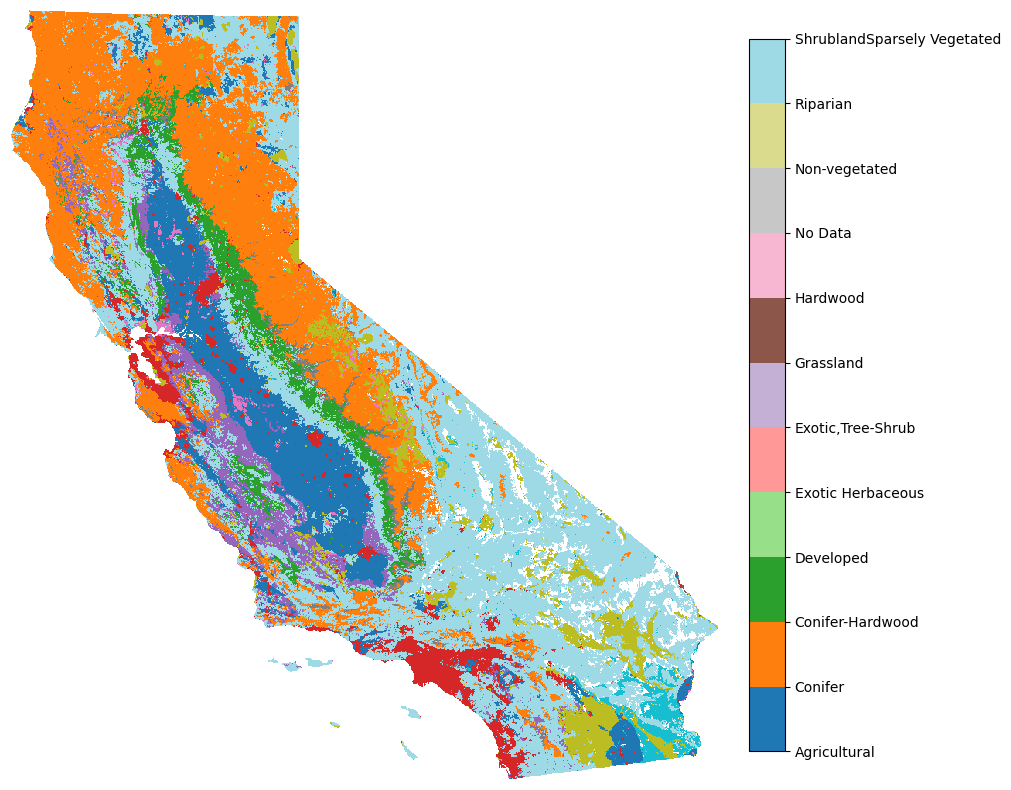

In [135]:
fig, ax = plt.subplots(figsize=(10, 10))
xr_resampled.plot(
    levels=cats,
    ax=ax,
    add_colorbar=False,
    # colors=plt.cm.tab20.colors[0:cats.shape[0] + 11],
    # cbar_kwargs={"ticks": cats, "boundaries": cats, "fraction": 0.046, "pad": 0.04},
    cmap="tab20",
)

# Create colorbar with 13 values using the tab10 colormap
cmap = plt.cm.tab20
bounds = cats
norm = plt.Normalize(bounds.min(), bounds.max())

labels = [
    "Agricultural",
    "Conifer",
    "Conifer-Hardwood",
    "Developed",
    "Exotic Herbaceous",
    "Exotic,Tree-Shrub",
    "Grassland",
    "Hardwood",
    "No Data",
    "Non-vegetated",
    "Riparian",
    "Shrubland" "Sparsely Vegetated",
]

cb = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=bounds,
    boundaries=bounds,
    orientation="vertical",
    fraction=0.046,
    pad=0.04,
)
cb.ax.set_yticklabels(labels)

# Remove legend
ax.get_legend()

# Remove axis
ax.axis("off")

# Remove title
ax.set_title("")